# American Option Pricing with Monte Carlo Simulation

This notebook explores the pricing of American options using Monte Carlo simulation techniques. It includes:

- Implementation of the Black-Scholes formula for European options as a benchmark.
- A custom Monte Carlo simulation function for American options, allowing for early exercise.
- Visualization of simulated stock price paths using geometric Brownian motion.
- Calculation of option Greeks (Delta, Gamma) via finite difference methods.
- Analysis of option price sensitivity to simulation parameters.
- Integration of historical stock and option data for real-world comparison.
- Delta hedging and PnL analysis based on simulated and actual option prices.
- Visualization and comparison of model prices to market prices across different strikes and maturities.

The notebook is modular, allowing for easy adjustment of parameters and extension to other assets or option types.

In [3]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt 
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from scipy.stats import norm
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from datetime import datetime as dt

Can do by making small change in price, but use same seed to generate same path.


## Black Scholes Formula 

In [2]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    gamma = norm.pdf(d1)/(S*sigma*np.sqrt(T))

    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return option_price, d1,d2, delta,gamma



## Monte Carlo Simulation Function 

In [3]:
def monte_carlo_american_option(S, K, T, r, sigma, option_type, n_simulations, n_steps):
    dt = T / n_steps
    df = np.exp(-r * dt)
    option_prices = []
    stock_prices = []
    intrinsic_values = []

    for _ in range(n_simulations):
        price_path = [S]
        if option_type == 'call':
                early_exercise = [S-K]
        elif option_type == 'put':
                early_exercise = [K-S]

        for _ in range(n_steps):
            z = np.random.standard_normal()
            S_t = price_path[-1] * np.exp((r - (sigma ** 2) / 2) * dt + sigma * np.sqrt(dt) * z)
            price_path.append(S_t)

            if option_type == 'call':
                early_exercise.append(max(S_t - K, 0))
            elif option_type == 'put':
                early_exercise.append(max(K - S_t, 0)) 
        
        stock_prices.append(price_path)
        intrinsic_values.append(early_exercise)
        
    stock_prices = np.array(stock_prices)    #matrix of stock price paths
    intrinsic_values = np.array(intrinsic_values) # matrix of how much payoff is if option is exercised 
    value_tracker = np.zeros_like(intrinsic_values)  # value matrix if exercise or continue
    value_tracker[:, -1] = intrinsic_values[:, -1]   # set last column equal to intrinsic value last column(like end of binomial tree)
    
    for t in range(n_steps- 1, 0, -1):
        good_paths = intrinsic_values[:, t] > 0  # paths where the intrinsic value is positive
        
        x = intrinsic_values[:, t] == 0
        y = np.count_nonzero(x)
        
        if y==n_simulations:
            C = np.zeros(n_simulations-1)
        
        # the regression is performed only on these paths 
        # There was an error that if the intrinsic_values[:, t] was all 0's then it would throw an error in the regression, maybe figure out how to get around this?
        else:
            x = stock_prices[good_paths, t]
            y = value_tracker[good_paths, t + 1] * df
            coefficients = np.polyfit(x, y, 2)
            # Evaluating the regression
            C = np.polyval(coefficients, x)
        
        exercise = np.zeros(len(good_paths), dtype=bool)  # create exercise array
        
        if len(intrinsic_values[good_paths,t]) == 0:
            C=[]
        else:
            pass
        exercise[good_paths] = intrinsic_values[good_paths, t] > C  # paths where it is optimal to exercise
        
        value_tracker[exercise, t] = intrinsic_values[exercise, t]  # set V equal to H where it is optimal to exercise
        
        value_tracker[exercise, t + 1 :] = 0  # set future cash flows, for that path, equal to zero
        
        discount_path = value_tracker[:, t] == 0  # paths where we didn't exercise
        
        value_tracker[discount_path, t] = value_tracker[discount_path, t + 1] * df  # set V[t] in continuation region
        
    option_price = np.mean(value_tracker[:, 1]) * df

    return option_price , stock_prices , value_tracker # Return a list of option prices


## Graph Brownian Motion to see stock paths

In [4]:
def graph_brownian_motion(stock_price_matrix):
    plt.xlabel('Steps')
    plt.ylabel('Stock Price')
    plt.title("Geometric Brownian Motion")
    for i in stock_price_matrix: plt.plot(i)
    plt.show()

## Testing Code

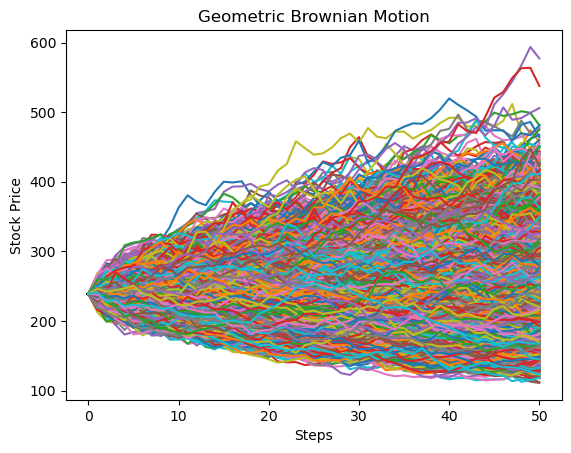

19.415271467881226

In [5]:
S0 = 238.83
K = 240

r = 0.0526
sigma = .46862
option_type = 'put'
n_simulations = 20000
n_steps = 50
T = n_steps/252

state = np.random.get_state()

output = monte_carlo_american_option(S0, K, T, r, sigma, option_type, n_simulations, n_steps)
option_price =output[0]
stock_price_matrix = output[1]
value_tracker_matrix = output[2]
graph = graph_brownian_motion(stock_price_matrix)
option_price

In [6]:
np.zeros(n_simulations)

array([0., 0., 0., ..., 0., 0., 0.])

## Changing the price a dollar higher and checking to make sure we get the seed so we can calc delta and gamma

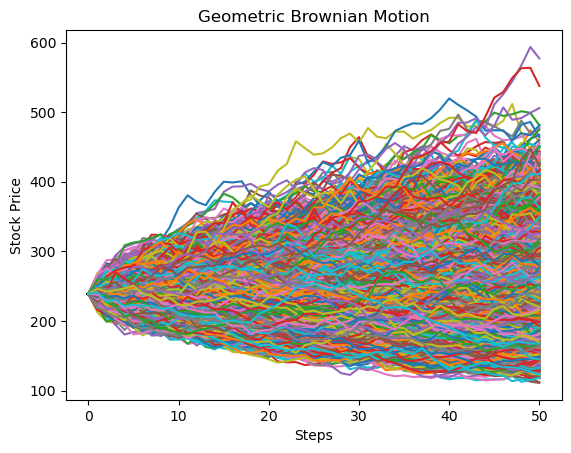

18.967609008625526

In [7]:
S1=239.83

np.random.set_state(state)

output_1 = monte_carlo_american_option(S1, K, T, r, sigma, option_type, n_simulations, n_steps)
option_price_1 = output_1[0]
stock_price_matrix_1 = output_1[1]
value_tracker_matrix_1 = output_1[2]
graph_1 = graph_brownian_motion(stock_price_matrix)
option_price_1

## Generate again at a lower price

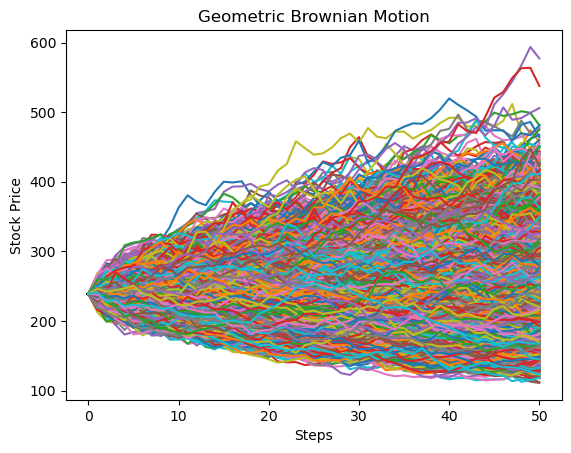

19.843507782238078

In [8]:
S2=237.83

np.random.set_state(state)

output_2 = monte_carlo_american_option(S2, K, T, r, sigma, option_type, n_simulations, n_steps)
option_price_2 = output_2[0]
stock_price_matrix_2 = output_2[1]
value_tracker_matrix_2 = output_2[2]
graph_2 = graph_brownian_motion(stock_price_matrix)
option_price_2

## Calculate Delta and Gamma and then test to see results and compare to BS

In [9]:
def delta(option_price , option_price_1 , S0,S1):
    delta = (option_price_1-option_price)/(S1-S0)
    return delta
delta_1 = delta(option_price , option_price_1 ,S0, S1)
delta_2 = delta(option_price , option_price_2, S0, S2)

In [10]:
print(delta_1,delta_2)

-0.4476624592556995 -0.4282363143568517


In [11]:
print((delta_1+delta_2)/2)

-0.4379493868062756


In [12]:
def gamma(delta_1, delta_2, S0, S1, S2):   
    gamma = abs(delta_1- delta_2)/(.5*abs(S2-S0)+.5*abs(S1-S0))
    return gamma
gamma(delta_1, delta_2, S0, S1 , S2)

0.019426144898847753

In [13]:
b_s = black_scholes(S0, K, T, r, sigma, option_type)
b_s

(19.143732115806998,
 0.13095609557547366,
 -0.07778384306619351,
 -0.4479050194362808,
 0.007933990375818139)

## Want to Create a Dataframe which outputs price, delta and gamma as time goes on

### Eventually want to have a price array from historical data that will take the price at that ttm and then give the simulated option price and the greeks, this could be useful to compare to the historical option price for that day, with that implied vol and calculate the greeks to compare

### Can also take the average of the next day sim price and see how doing this throughout time will perform. Can combine this with delta hedging to see how it can perform in relation to actual movement of the stock and the options price

In [14]:
# want to eventually incorporate taking a matrix or array of stock prices from historicals and 
# then can watch how this prices and figures out delta in comparison to historicals
# can maybe try to average the stock price matrix and use that as next S0 too 

def calc_over_time(S0, K, T, r, sigma, option_type, n_simulations, n_steps, stop, time_test = False):
    n_steps = n_steps
    T=T
    dt = T / n_steps
    option_prices_df = pd.DataFrame()
    times_to_maturity = []
    stock_prices = []
    option_prices =[]
    deltas = []
    gammas = []
    
    next_day_avg_price = S0
    while (n_steps > stop) :
        
        if time_test == False :
            S0=next_day_avg_price
        else:
            S0=S0 
        
        state = np.random.get_state()

        output = monte_carlo_american_option(S0, K, T, r, sigma, option_type, n_simulations, n_steps)
        option_price_0 =output[0]
        stock_price_matrix_0 = output[1]
        next_day_avg_price = stock_price_matrix_0[:,1].mean()
        value_tracker_matrix_0 = output[2]
        
        S1=S0+1
        np.random.set_state(state)

        output_1 = monte_carlo_american_option(S1, K, T, r, sigma, option_type, n_simulations, n_steps)
        option_price_1 = output_1[0]
        delta_1 = delta(option_price_0,option_price_1,S0,S1)
        
        S2=S0-1
        np.random.set_state(state)

        output_2 = monte_carlo_american_option(S2, K, T, r, sigma, option_type, n_simulations, n_steps)
        option_price_2 = output_2[0]
        delta_2 = delta(option_price_0,option_price_2,S0,S2)
        gamma_1 = gamma(delta_1, delta_2, S0, S1, S2)
        
        times_to_maturity.append(T)
        stock_prices.append(S0)
        option_prices.append(option_price_0)
        delta_avg = (delta_1+delta_2)/2
        deltas.append(delta_avg)
        gammas.append(gamma_1)
        
        n_steps=n_steps-1
        T=T-dt
        
    option_prices_df['Time to Maturity'] = times_to_maturity
    option_prices_df['Asset Price'] = stock_prices
    option_prices_df['Option Price'] = option_prices
    option_prices_df['Delta'] = deltas 
    #option_prices_df['Delta 2'] = delta_2s 
    option_prices_df['Gamma'] = gammas 
    return option_prices_df

In [16]:
#14.7 last price, 14.6,14.75 bid,ask
S0 = 240 #11/15 closing price:242.84
S1 = 260
S2 = 220
K = 240  #for this strike
n_steps = 22 #11/15/23 days until exp
stop = 0 #days until 12/15/23
T = n_steps/252
r = 0.05
sigma = .4827
option_type = 'call'
n_simulations = 1000
#see how time impacts options
time_df_C_ATM = calc_over_time(S0, K, T, r, sigma, option_type, n_simulations, n_steps, stop, time_test = True)
time_df_C_ITM = calc_over_time(S1, K, T, r, sigma, option_type, n_simulations, n_steps, stop, time_test = True)
time_df_C_OTM = calc_over_time(S2, K, T, r, sigma, option_type, n_simulations, n_steps, stop, time_test = True)
option_type = 'put'
time_df_P_ATM = calc_over_time(S0, K, T, r, sigma, option_type, n_simulations, n_steps, stop, time_test = True)
time_df_P_OTM = calc_over_time(S1, K, T, r, sigma, option_type, n_simulations, n_steps, stop, time_test = True)
time_df_P_ITM = calc_over_time(S2, K, T, r, sigma, option_type, n_simulations, n_steps, stop, time_test = True)

C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit

In [17]:
time_df_C_ATM

,Time to Maturity,Asset Price,Option Price,Delta,Gamma
0,0.087302,240,15.229881,0.596110,0.006525
1,0.083333,240,13.926902,0.518116,0.072373
2,0.079365,240,14.176205,0.619696,0.120526
3,0.075397,240,13.790566,0.560882,0.085776
4,0.071429,240,12.133425,0.487002,0.035896
5,0.067460,240,12.620042,0.545501,0.117682
6,0.063492,240,12.432282,0.439946,0.206373
7,0.059524,240,11.691741,0.539298,0.419035
8,0.055556,240,10.921745,0.486830,0.124963
9,0.051587,240,11.490355,0.547657,0.048944


In [18]:
calc_over_time(S0, K, T, r, sigma, option_type, n_simulations, n_steps, stop, time_test = False)

,Time to Maturity,Asset Price,Option Price,Delta,Gamma
0,0.087302,240.000000,12.739246,-0.513182,0.143937
1,0.083333,240.177381,12.745046,-0.461914,0.039844
2,0.079365,240.293636,13.282870,-0.441782,0.116211
3,0.075397,240.374538,12.582545,-0.515340,0.043626
4,0.071429,240.506983,11.575736,-0.524918,0.152989
5,0.067460,240.595273,12.207359,-0.476599,0.001487
6,0.063492,240.400357,11.489760,-0.514363,0.065690
7,0.059524,240.859898,10.324613,-0.412836,0.099662
8,0.055556,240.774596,10.941437,-0.461312,0.028319
9,0.051587,240.814415,9.706732,-0.475240,0.034746


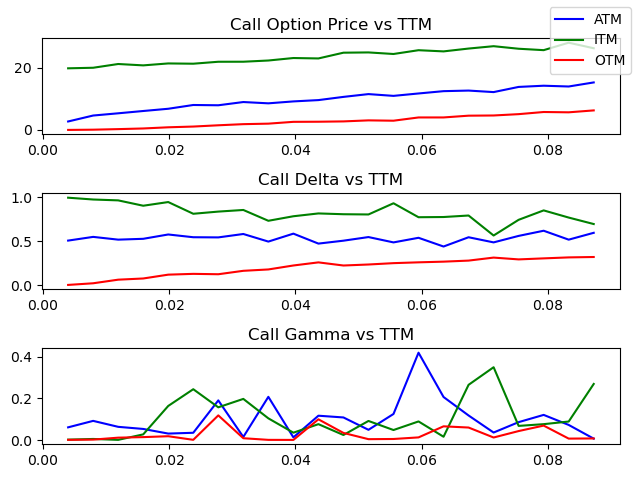

In [19]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3)
ax1.plot(time_df_C_ATM['Time to Maturity'], time_df_C_ATM['Option Price'],color='blue')
ax1.plot(time_df_C_ITM['Time to Maturity'], time_df_C_ITM['Option Price'],color='green')
ax1.plot(time_df_C_OTM['Time to Maturity'], time_df_C_OTM['Option Price'],color='red')
ax1.set_title("Call Option Price vs TTM")


ax2.plot(time_df_C_ATM['Time to Maturity'], time_df_C_ATM['Delta'],color='blue')
ax2.plot(time_df_C_ITM['Time to Maturity'], time_df_C_ITM['Delta'],color='green')
ax2.plot(time_df_C_OTM['Time to Maturity'], time_df_C_OTM['Delta'],color='red')
ax2.set_title("Call Delta vs TTM")


ax3.plot(time_df_C_ATM['Time to Maturity'], time_df_C_ATM['Gamma'],color='blue')
ax3.plot(time_df_C_ITM['Time to Maturity'], time_df_C_ITM['Gamma'],color='green')
ax3.plot(time_df_C_OTM['Time to Maturity'], time_df_C_OTM['Gamma'],color='red')
ax3.set_title("Call Gamma vs TTM")
plt.figlegend(labels = ["ATM","ITM","OTM"])

fig.tight_layout()
plt.show()

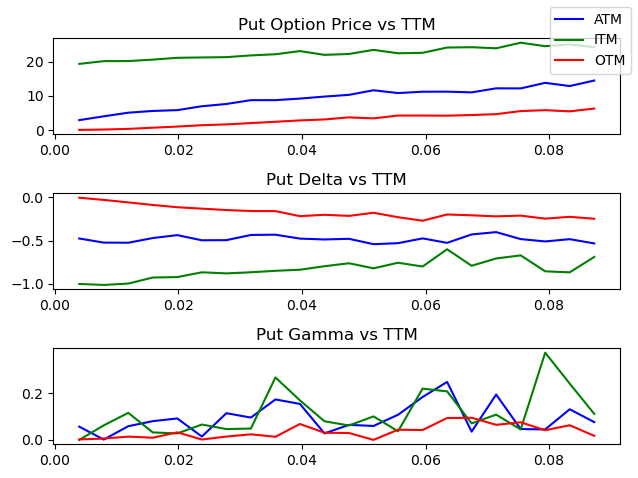

In [20]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3)
ax1.plot(time_df_P_ATM['Time to Maturity'], time_df_P_ATM['Option Price'],color='blue')
ax1.plot(time_df_P_ITM['Time to Maturity'], time_df_P_ITM['Option Price'],color='green')
ax1.plot(time_df_P_OTM['Time to Maturity'], time_df_P_OTM['Option Price'],color='red')
ax1.set_title("Put Option Price vs TTM")


ax2.plot(time_df_P_ATM['Time to Maturity'], time_df_P_ATM['Delta'],color='blue')
ax2.plot(time_df_P_ITM['Time to Maturity'], time_df_P_ITM['Delta'],color='green')
ax2.plot(time_df_P_OTM['Time to Maturity'], time_df_P_OTM['Delta'],color='red')
ax2.set_title("Put Delta vs TTM")


ax3.plot(time_df_P_ATM['Time to Maturity'], time_df_P_ATM['Gamma'],color='blue')
ax3.plot(time_df_P_ITM['Time to Maturity'], time_df_P_ITM['Gamma'],color='green')
ax3.plot(time_df_P_OTM['Time to Maturity'], time_df_P_OTM['Gamma'],color='red')
ax3.set_title("Put Gamma vs TTM")
plt.figlegend(labels = ["ATM","ITM","OTM"])

fig.tight_layout()
plt.show()

In [21]:
b_s = black_scholes(S0, K, T, r, sigma, option_type)
b_s

(13.097983544823848,
 0.1019171059922526,
 -0.04070550041059945,
 -0.4594112360228777,
 0.011594577449645533)

## Seeing if it is better to run multiple iterations of many sims and then average this to get a mean price, maybe improves accuracy

In [22]:
def option_value_tracker(S0, K, T, r, sigma, option_type, n_simulations, n_steps, n_iterations, graph=0):
    expected_values = np.zeros(n_iterations)
    if graph == 1:
        for i in range(n_iterations):
            output = monte_carlo_american_option(S0, K, T, r, sigma, option_type, n_simulations, n_steps)
            option_price = output[0]
            stock_price_matrix = output[1]
            expected_values[i]= option_price
            graph = graph_brownian_motion(stock_price_matrix)
    else:
        for i in range(n_iterations):
            output = monte_carlo_american_option(S0, K, T, r, sigma, option_type, n_simulations, n_steps)
            option_price = output[0]
            expected_values[i]= option_price
    return expected_values

In [23]:
n_iterations = 5
option_prices = option_value_tracker(S0, K, T, r, sigma, option_type, n_simulations, n_steps, n_iterations)
option_prices

array([12.83259413, 12.97166471, 13.38943282, 13.40975424, 13.49630124])

In [24]:
np.mean(option_prices)

13.21994942696162

## Sensitivity to Number of Simulations Analysis

In [25]:
n_sims_arr_1 = np.arange(10,5000,100)
n_sims_arr = np.arange(5000,50001,5000)
def test_n_sims(n_sims_arr, S0, K, T, r, sigma, option_type, n_steps):
    prices = []
    for n_simulations in n_sims_arr:
        
        output = monte_carlo_american_option(S0, K, T, r, sigma, option_type, n_simulations, n_steps)
        price =output[0]
        prices.append(price)
    
    return prices

In [26]:
S0 = 205.66
K = 200
T = .12
r = 0.05
sigma = .4827
option_type = 'call'
n_steps = 30

call_prices = test_n_sims(n_sims_arr, S0, K, T, r, sigma, option_type, n_steps)
call_prices_1 = test_n_sims(n_sims_arr_1, S0, K, T, r, sigma, option_type, n_steps)
option_type = 'put'
put_prices = test_n_sims(n_sims_arr, S0, K, T, r, sigma, option_type, n_steps)
put_prices_1 = test_n_sims(n_sims_arr_1, S0, K, T, r, sigma, option_type, n_steps)


KeyboardInterrupt: 

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(n_sims_arr_1, call_prices_1)
ax1.set_title("Few Sims Call")

ax2.plot(n_sims_arr,call_prices,'tab:orange')
ax2.set_title("Many Sims Call")

ax3.plot(n_sims_arr_1, put_prices_1,'tab:green')
ax3.set_title("Few Sims Put")

ax4.plot(n_sims_arr,put_prices,'tab:red')
ax4.set_title("Many Sims Put")

fig.tight_layout()

## Read in Historical Price Data, risk free rate and calculate volatility from this

In [4]:
ticker = "TSLA"
period = "6mo"
interval = "1d"
start = "2023-06-01"
start_1 = "2023-09-01"
start_2 = "2023-11-01"
start_3 = "2023-11-15"
end = "2023-12-01"

def get_historical_data(ticker, start, end, interval):
    data = round(yf.download(ticker, start=start,end=end,interval = interval),2)
    return data
def get_risk_free(start , end ,interval):
    rf= round(yf.download("^IRX", start=start,end=end,interval = interval)['Adj Close'].mean(),2)/100
    return rf

In [5]:
data = get_historical_data(ticker, start, end, interval)
data_1 = get_historical_data(ticker, start_1, end, interval)
data_2 = get_historical_data(ticker, start_2, end, interval)
data_3 = get_historical_data(ticker, start_3, end, interval)
rf = get_risk_free(start,end, interval)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
data.tail()
def historical_vol(df):    
    df["Log Returns"] = np.log(df["Adj Close"]) - np.log(df["Adj Close"].shift(1))
    df["Simple Returns"] = df["Adj Close"].pct_change()
    df = df[["Adj Close","Log Returns","Simple Returns"]]
    length = len(df)
    T = length/252
    log_ret = np.std(df["Log Returns"])
    simp_ret = np.std(df["Simple Returns"])
    historic_log_vol = np.sqrt(252)*log_ret
    std_error = historic_log_vol/np.sqrt(2*(length-1))
    return str(historic_log_vol)+" +/- "+str(std_error), df["Log Returns"], df["Simple Returns"], historic_log_vol
    

In [7]:
six_m_vol = historical_vol(data)[0]
log_ret = historical_vol(data)[1]
simple_ret = historical_vol(data)[2]
three_m_vol = historical_vol(data_1)[0]
one_m_vol = historical_vol(data_2)[0]
two_w_vol = historical_vol(data_3)[0]
sigma_6= historical_vol(data)[3]
sigma_3= historical_vol(data_1)[3]
sigma_1= historical_vol(data_2)[3]
sigma_2w = historical_vol(data_3)[3]
sigmas = [ 0.5009300757766552, 0.4959531028911172, 0.4686274757701408,0.3662065279376032]
print("The 6 month vol is "+ six_m_vol,"\n" 
      "The 3 month vol is "+ three_m_vol,"\n" 
      "The 1 month vol is "+ one_m_vol,"\n"
     "The 2 week vol is "+ two_w_vol)

The 6 month vol is 0.5009300757766552 +/- 0.03155562868423262 
The 3 month vol is 0.4959531028911172 +/- 0.04453790341793764 
The 1 month vol is 0.4686274757701408 +/- 0.07409650987845073 
The 2 week vol is 0.3662065279376032 +/- 0.08188626902726566


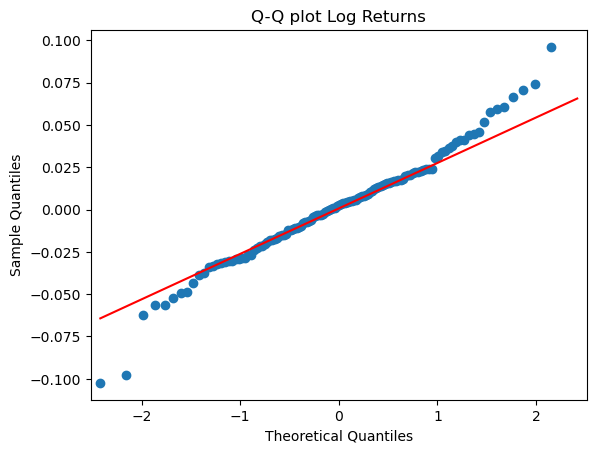

In [17]:
fig, (ax1) = plt.subplots(1)


fig= sm.qqplot(log_ret,ax=ax1,line = 'q')
ax1.set_title("Q-Q plot Log Returns")

plt.show()

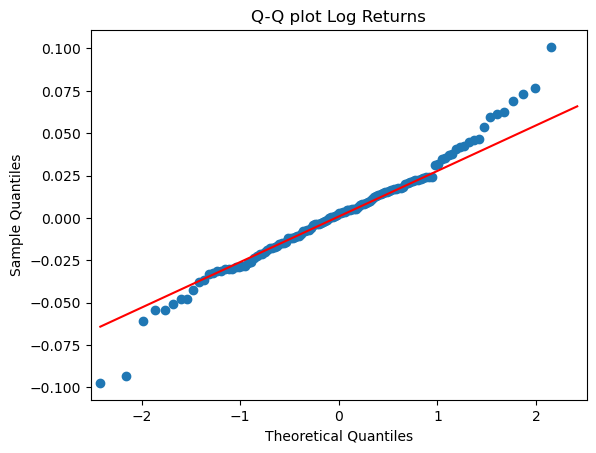

In [18]:
fig, (ax1) = plt.subplots(1)


fig= sm.qqplot(simple_ret,ax=ax1,line = 'q')
ax1.set_title("Q-Q plot Log Returns")

plt.show()

<Axes: title={'center': "Tesla's stock price (6 mo)"}, xlabel='Date'>

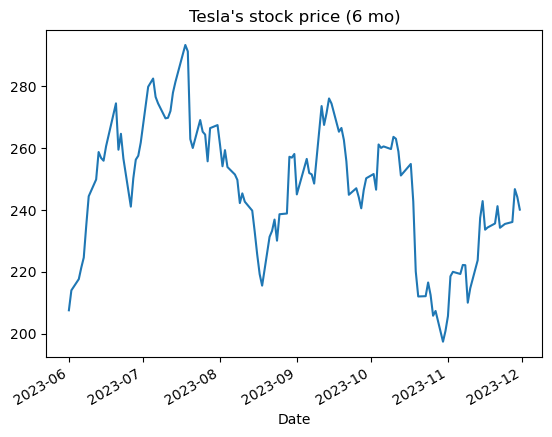

In [32]:
data['Adj Close'].plot(title="Tesla's stock price (6 mo)")

In [20]:
historical_option_data = pd.read_csv(r"C:\Users\bjorn\Pricing Models\Options Data TSLA - Sheet1.csv")

In [21]:
historical_option_data = historical_option_data.set_axis(['Date', 'Adj Close', 'Strike 220C', 'Close 220C', 'Bid 220C', 'Ask 220C',
                                'Strike 225C', 'Close 225C', 'Bid 225C', 'Ask 225C',
                                 'Strike 230C', 'Close 230C', 'Bid 230C', 'Ask 230C',
                                 'Strike 235C', 'Close 235C', 'Bid 235C', 'Ask 235C',
                                 'Strike 240C', 'Close 240C', 'Bid 240C', 'Ask 240C',
                                 'Strike 245C', 'Close 245C', 'Bid 245C', 'Ask 245C',
                                 'Strike 250C', 'Close 250C', 'Bid 250C', 'Ask 250C',
                                 'Strike 255C', 'Close 255C', 'Bid 255C', 'Ask 255C',
                                 'Strike 260C', 'Close 260C', 'Bid 260C', 'Ask 260C',
                                 'Strike 220P', 'Close 220P', 'Bid 220P', 'Ask 220P',
                                 'Strike 225P', 'Close 225P', 'Bid 225P', 'Ask 225P',
                                 'Strike 230P', 'Close 230P', 'Bid 230P', 'Ask 230P',
                                 'Strike 235P', 'Close 235P', 'Bid 235P', 'Ask 235P',
                                 'Strike 240P', 'Close 240P', 'Bid 240P', 'Ask 240P',
                                 'Strike 245P', 'Close 245P', 'Bid 245P', 'Ask 245P',
                                 'Strike 250P', 'Close 250P', 'Bid 250P', 'Ask 250P',
                                 'Strike 255P', 'Close 255P', 'Bid 255P', 'Ask 255P',
                                 'Strike 260P', 'Close 260P', 'Bid 260P', 'Ask 260P'
                                ], axis=1)
historical_option_data.head()

,Date,Adj Close,Strike 220C,Close 220C,Bid 220C,Ask 220C,Strike 225C,Close 225C,Bid 225C,Ask 225C,...,Bid 250P,Ask 250P,Strike 255P,Close 255P,Bid 255P,Ask 255P,Strike 260P,Close 260P,Bid 260P,Ask 260P
0,6/1/2023,207.52,220,29.30,29.3,29.70,225,27.43,27.05,27.75,...,55.80,57.05,255,63.90,59.50,60.55,260,67.40,63.35,64.35
1,6/2/2023,213.97,220,32.90,32.6,33.20,225,31.50,30.40,30.95,...,51.80,52.90,255,63.90,55.35,56.45,260,58.05,59.05,60.15
2,6/5/2023,217.61,220,34.70,34.5,35.00,225,31.30,32.35,32.90,...,49.65,50.25,255,63.90,53.15,53.95,260,56.42,56.75,57.55
3,6/6/2023,221.31,220,36.45,36.5,37.10,225,34.75,34.25,34.70,...,47.00,47.95,255,63.90,50.45,51.20,260,56.42,53.95,54.70
4,6/7/2023,224.57,220,37.48,37.9,39.35,225,36.19,35.55,36.25,...,43.65,47.20,255,46.25,48.10,48.95,260,50.00,51.55,52.40


In [22]:
hist_call_data = historical_option_data.iloc[:,0:38]
hist_put_data = historical_option_data.iloc[:, np.r_[0:2,38:74]]

In [23]:
hist_call_data.head()

,Date,Adj Close,Strike 220C,Close 220C,Bid 220C,Ask 220C,Strike 225C,Close 225C,Bid 225C,Ask 225C,...,Bid 250C,Ask 250C,Strike 255C,Close 255C,Bid 255C,Ask 255C,Strike 260C,Close 260C,Bid 260C,Ask 260C
0,6/1/2023,207.52,220,29.30,29.3,29.70,225,27.43,27.05,27.75,...,19.30,19.70,255,18.13,18.05,18.45,260,17.27,16.85,17.15
1,6/2/2023,213.97,220,32.90,32.6,33.20,225,31.50,30.40,30.95,...,21.90,22.25,255,20.70,20.55,20.85,260,19.50,19.20,19.55
2,6/5/2023,217.61,220,34.70,34.5,35.00,225,31.30,32.35,32.90,...,23.25,23.70,255,22.10,21.90,22.15,260,20.83,20.50,20.80
3,6/6/2023,221.31,220,36.45,36.5,37.10,225,34.75,34.25,34.70,...,24.65,25.25,255,22.55,23.10,23.65,260,21.90,21.70,22.05
4,6/7/2023,224.57,220,37.48,37.9,39.35,225,36.19,35.55,36.25,...,25.80,27.45,255,24.45,24.00,25.35,260,22.75,22.55,22.95


In [24]:
hist_june_call = pd.DataFrame()
hist_june_call['Date'] = hist_call_data['Date']
hist_june_call['Adj Close'] = hist_call_data['Adj Close']
for i in [220,225,230,235,240,245,250,255,260]:
    hist_june_call['Close '+str(i)+'C'] = hist_call_data['Close '+str(i)+'C']

    

In [25]:
hist_june_call[109:]

,Date,Adj Close,Close 220C,Close 225C,Close 230C,Close 235C,Close 240C,Close 245C,Close 250C,Close 255C,Close 260C
109,11/6/2023,219.27,13.45,11.00,8.95,7.25,5.79,4.50,3.60,2.85,2.24
110,11/7/2023,222.18,14.89,12.40,10.07,8.25,6.57,5.20,4.13,3.30,2.60
111,11/8/2023,222.11,14.45,11.90,9.65,7.77,6.16,4.85,3.85,3.00,2.35
112,11/9/2023,209.98,8.35,6.65,5.21,4.10,3.19,2.51,1.99,1.54,1.22
113,11/10/2023,214.65,10.01,8.00,6.30,4.91,3.85,2.96,2.30,1.78,1.40
114,11/13/2023,223.71,14.95,12.22,9.90,7.92,6.24,4.95,3.90,3.00,2.41
115,11/14/2023,237.41,23.40,19.95,17.04,14.25,11.60,9.22,7.50,6.00,4.75
116,11/15/2023,242.84,28.05,24.30,20.78,17.54,14.70,12.10,9.91,8.05,6.50
117,11/16/2023,233.59,21.26,17.25,14.30,11.65,9.45,7.56,6.00,4.76,3.75
118,11/17/2023,234.30,21.00,17.80,14.65,11.90,9.57,7.62,6.05,4.71,3.65


In [26]:
hist_june_put = pd.DataFrame()
hist_june_put['Date'] = hist_put_data['Date']
hist_june_put['Adj Close'] = hist_put_data['Adj Close']
for i in [220,225,230,235,240,245,250,255,260]:    
    hist_june_put['Close '+str(i)+'P'] = hist_put_data['Close '+str(i)+'P']

In [27]:
len(hist_june_call[80:])

50

In [28]:
def calc_over_time_1(S0_series, K, T, r, sigma, option_type, n_simulations, n_steps, stop, actual_option_price):
    n_steps = n_steps
    T=T
    dt = T / n_steps
    option_prices_df = pd.DataFrame()
    times_to_maturity = []
    stock_prices = []
    option_prices =[]
    deltas = []
    gammas = []
    
    i = 0
    while (n_steps > stop) :
        
        S0 = S0_series[i]
        state = np.random.get_state()

        output = monte_carlo_american_option(S0, K, T, r, sigma, option_type, n_simulations, n_steps)
        option_price_0 =output[0]
        stock_price_matrix_0 = output[1]
        next_day_avg_price = stock_price_matrix_0[:,1].mean()
        value_tracker_matrix_0 = output[2]
        
        S1=S0+1
        np.random.set_state(state)

        output_1 = monte_carlo_american_option(S1, K, T, r, sigma, option_type, n_simulations, n_steps)
        option_price_1 = output_1[0]
        delta_1 = delta(option_price_0,option_price_1,S0,S1)
        
        S2=S0-1
        np.random.set_state(state)

        output_2 = monte_carlo_american_option(S2, K, T, r, sigma, option_type, n_simulations, n_steps)
        option_price_2 = output_2[0]
        delta_2 = delta(option_price_0,option_price_2,S0,S2)
        gamma_1 = gamma(delta_1, delta_2, S0, S1, S2)
        
        times_to_maturity.append(T)
        stock_prices.append(S0)
        option_prices.append(option_price_0)
        delta_avg = (delta_1+delta_2)/2
        deltas.append(delta_avg)
        gammas.append(gamma_1)
        
        delta_avg
        
        
        
        n_steps=n_steps-1
        T=T-dt
        i+=1
        
     
    
    
    
    option_prices_df['Time to Maturity'] = times_to_maturity
    option_prices_df['Asset Price'] = stock_prices
    option_prices_df['Actual Option Price'] = actual_option_price.to_numpy()
    option_prices_df['Option Price'] = option_prices
    option_prices_df['Delta'] = deltas 
    #option_prices_df['Delta 2'] = delta_2s 
    option_prices_df['Gamma'] = gammas 
    
    
  
    shares_purchase_0 = option_prices_df['Delta'][0]*1000
    shares_purchase = (option_prices_df['Delta']-option_prices_df['Delta'].shift(1))*1000
    shares_purchase = shares_purchase[1:]
    shares_purchased = [shares_purchase_0]
    for shares_purchase_ in shares_purchase:
        shares_purchased.append(shares_purchase_)
        
    daily_costs = []    
    for i in range(len(shares_purchased)):
        daily_cost = shares_purchased[i]*option_prices_df['Asset Price'][i]
        daily_costs.append(daily_cost)
        
    cumulative = np.cumsum(daily_costs)
    shares_held = np.cumsum(shares_purchased)
    option_prices_df['Shares Purchased'] = shares_purchased
    option_prices_df['Daily Cost'] = daily_costs
    option_prices_df['Cumulative Cost'] = cumulative
    option_prices_df['Total Shares Held'] = shares_held
    
    pnl_unhedged_vector = -(option_prices_df['Actual Option Price']-option_prices_df['Actual Option Price'].shift(1))*1000
    pnl_hedged_vector = -(option_prices_df['Actual Option Price']-option_prices_df['Actual Option Price'].shift(1))*1000 + (option_prices_df['Asset Price']-option_prices_df['Asset Price'].shift(1))*option_prices_df['Delta'].shift(1)*1000
    option_prices_df['PnL Unhedged'] = pnl_unhedged_vector
    option_prices_df['Cum PnL Unhedged'] = np.cumsum(pnl_unhedged_vector)
    option_prices_df['Pnl Hedged']  = pnl_hedged_vector
    option_prices_df['Cum Pnl Hedged']  = np.cumsum(pnl_hedged_vector)

    
    
    return option_prices_df

In [42]:
S0_series = hist_june_call['Adj Close'][109:]
S0_series = S0_series.reset_index()
S0_series = S0_series.drop(['index'], axis= 1)
S0_series = S0_series['Adj Close']
stop = 7
n_steps= len(S0_series)+stop
T= n_steps/252
sigma=sigmas[2]
option_type ='call'
n_simulations = 20000
K=240
r=rf
actual_option_price = hist_june_call["Close 240C"][109:]

In [43]:
Call_240_1mo = calc_over_time_1(S0_series, K, T, r, sigma, option_type, n_simulations, n_steps, stop,actual_option_price)

C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)


In [44]:
option_type ='put'
actual_option_price = hist_june_put["Close 240P"][109:]
Put_240_1mo = calc_over_time_1(S0_series, K, T, r, sigma, option_type, n_simulations, n_steps, stop,actual_option_price)

In [29]:
Call_240_1mo.head()

NameError: name 'Call_240_1mo' is not defined

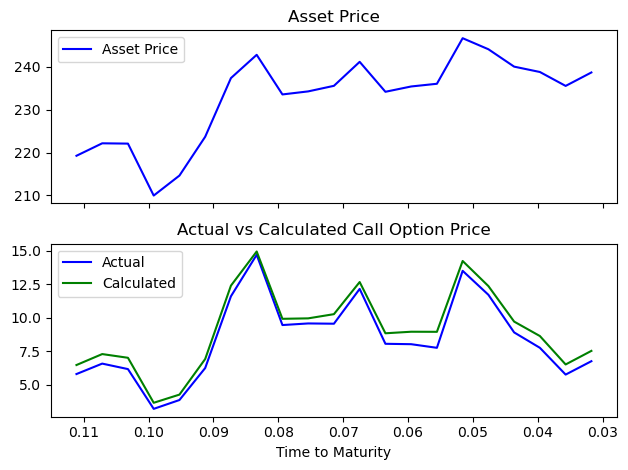

In [121]:
fig, ((ax1, ax2)) = plt.subplots(2,sharex= True)

ax1.plot(Call_240_1mo['Time to Maturity'], Call_240_1mo['Asset Price'],color='blue',label='Asset Price')
ax1.set_title("Asset Price")

ax1.legend()

ax2.plot(Call_240_1mo['Time to Maturity'], Call_240_1mo['Actual Option Price'],color='blue',label='Actual')
ax2.plot(Call_240_1mo['Time to Maturity'], Call_240_1mo['Option Price'],color='green',label = 'Calculated')
ax2.set_title("Actual vs Calculated Call Option Price")
ax2.invert_xaxis()
ax2.legend()

ax2.set_xlabel('Time to Maturity')
fig.tight_layout()
plt.show()

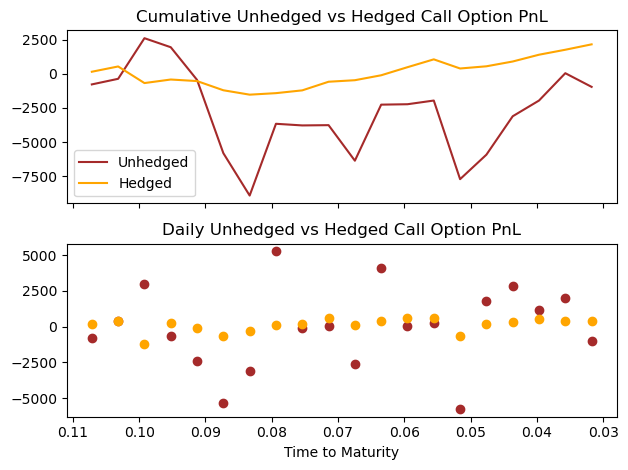

In [120]:
fig, ((ax1, ax2)) = plt.subplots(2,sharex=True)
ax1.plot(Call_240_1mo['Time to Maturity'], Call_240_1mo['Cum PnL Unhedged'],color='brown',label = 'Unhedged')
ax1.plot(Call_240_1mo['Time to Maturity'], Call_240_1mo['Cum Pnl Hedged'],color='orange', label ='Hedged')
ax1.set_title("Cumulative Unhedged vs Hedged Call Option PnL")
ax1.legend(loc ='lower left')

ax2.scatter(Call_240_1mo['Time to Maturity'], Call_240_1mo['PnL Unhedged'],color='brown',label = 'Unhedged')
ax2.scatter(Call_240_1mo['Time to Maturity'], Call_240_1mo['Pnl Hedged'],color='orange', label ='Hedged')
ax2.set_title("Daily Unhedged vs Hedged Call Option PnL")
ax2.invert_xaxis()
ax2.set_xlabel('Time to Maturity')

fig.tight_layout()
plt.show()

In [72]:
Put_240_1mo.head()

,Time to Maturity,Asset Price,Actual Option Price,Option Price,Delta,Gamma,Shares Purchased,Daily Cost,Cumulative Cost,Total Shares Held,PnL Unhedged,Cum PnL Unhedged,Pnl Hedged,Cum Pnl Hedged
0,0.111111,219.27,25.45,26.168098,-0.684488,0.016311,-684.488406,-150087.772703,-150087.772703,-684.488406,NaN,NaN,NaN,NaN
1,0.107143,222.18,23.25,23.759570,-0.649677,0.013159,34.811552,7734.430688,-142353.342014,-649.676853,2200.0,2200.0,208.138740,208.138740
2,0.103175,222.11,22.15,24.079684,-0.664050,0.030797,-14.373551,-3192.509370,-145545.851384,-664.050404,1100.0,3300.0,1145.477380,1353.616119
3,0.099206,209.98,33.35,32.550741,-0.795385,0.099627,-131.334954,-27577.713643,-173123.565028,-795.385358,-11200.0,-7900.0,-3145.068598,-1791.452478
4,0.095238,214.65,28.19,28.773593,-0.742691,0.032121,52.694200,11310.810091,-161812.754936,-742.691158,5160.0,-2740.0,1445.550377,-345.902101


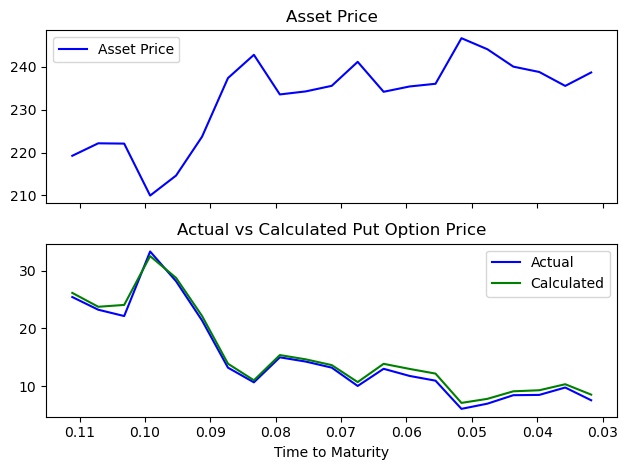

In [117]:
fig, ((ax1, ax2)) = plt.subplots(2,sharex=True)

ax1.plot(Put_240_1mo['Time to Maturity'], Put_240_1mo['Asset Price'],color='blue',label='Asset Price')
ax1.set_title("Asset Price")
ax1.legend()

ax2.plot(Put_240_1mo['Time to Maturity'], Put_240_1mo['Actual Option Price'],color='blue',label='Actual')
ax2.plot(Put_240_1mo['Time to Maturity'], Put_240_1mo['Option Price'],color='green',label = 'Calculated')
ax2.set_title("Actual vs Calculated Put Option Price")
ax2.invert_xaxis()
ax2.legend()
ax2.set_xlabel('Time to Maturity')
fig.tight_layout()

plt.show()

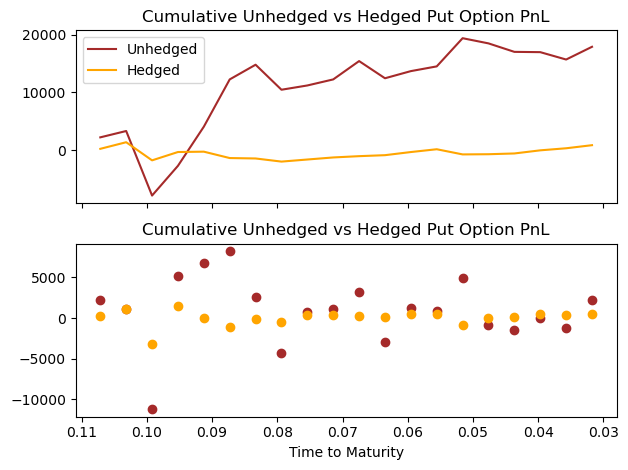

In [119]:
fig, ((ax1, ax2)) = plt.subplots(2,sharex=True)
ax1.plot(Put_240_1mo['Time to Maturity'], Put_240_1mo['Cum PnL Unhedged'],color='brown',label = 'Unhedged')
ax1.plot(Put_240_1mo['Time to Maturity'], Put_240_1mo['Cum Pnl Hedged'],color='orange', label ='Hedged')
ax1.set_title("Cumulative Unhedged vs Hedged Put Option PnL")
ax1.legend(loc ='upper left')

ax2.scatter(Put_240_1mo['Time to Maturity'], Put_240_1mo['PnL Unhedged'],color='brown',label = 'Unhedged')
ax2.scatter(Put_240_1mo['Time to Maturity'], Put_240_1mo['Pnl Hedged'],color='orange', label ='Hedged')
ax2.set_title("Cumulative Unhedged vs Hedged Put Option PnL")
ax2.invert_xaxis()
ax2.set_xlabel('Time to Maturity')

fig.tight_layout()
plt.show()

In [48]:
hist_june_put[119:]

,Date,Adj Close,Close 220P,Close 225P,Close 230P,Close 235P,Close 240P,Close 245P,Close 250P,Close 255P,Close 260P
119,11/20/2023,235.60,4.79,6.27,8.10,10.30,13.20,15.90,19.30,22.95,26.93
120,11/21/2023,241.20,3.40,4.55,6.01,7.70,10.02,12.50,15.55,18.63,22.55
121,11/22/2023,234.21,4.52,6.00,7.97,10.41,13.00,16.25,20.30,23.65,28.25
122,11/24/2023,235.45,3.75,5.15,6.75,9.10,11.76,14.05,18.41,21.65,25.00
123,11/27/2023,236.08,3.20,4.50,6.22,8.30,10.94,14.00,16.90,20.93,24.60
124,11/28/2023,246.72,1.44,2.13,3.10,4.32,6.05,8.15,10.69,13.70,17.15
125,11/29/2023,244.14,1.72,2.51,3.60,5.15,6.95,9.35,12.20,15.40,19.40
126,11/30/2023,240.08,2.06,3.05,4.41,6.25,8.42,11.15,14.60,18.77,22.05
127,12/1/2023,238.83,1.90,2.87,4.29,6.14,8.47,11.35,14.82,18.70,23.15
128,12/4/2023,235.58,2.09,3.30,4.85,7.01,9.75,13.05,16.82,20.97,24.50


In [49]:
df_only_close = pd.DataFrame()
df_only_close['Date'] = historical_option_data['Date']
df_only_close['Adj Close'] = historical_option_data['Adj Close']
for i in [220,225,230,235,240,245,250,255,260]:
    df_only_close['Close '+str(i)+'C'] = historical_option_data['Close '+str(i)+'C']
    df_only_close['Close '+str(i)+'P'] = historical_option_data['Close '+str(i)+'P']
    

In [50]:
df_only_close.head()

,Date,Adj Close,Close 220C,Close 220P,Close 225C,Close 225P,Close 230C,Close 230P,Close 235C,Close 235P,Close 240C,Close 240P,Close 245C,Close 245P,Close 250C,Close 250P,Close 255C,Close 255P,Close 260C,Close 260P
0,6/1/2023,207.52,29.30,38.20,27.43,39.50,25.96,43.15,24.85,44.9,22.27,48.97,21.20,51.85,19.50,56.00,18.13,63.90,17.27,67.40
1,6/2/2023,213.97,32.90,33.30,31.50,36.05,28.89,39.10,27.33,41.6,25.90,44.60,24.01,47.83,22.20,51.46,20.70,63.90,19.50,58.05
2,6/5/2023,217.61,34.70,32.68,31.30,35.00,30.14,38.35,28.10,41.0,26.85,43.25,25.08,47.83,23.48,50.25,22.10,63.90,20.83,56.42
3,6/6/2023,221.31,36.45,29.80,34.75,32.20,30.95,35.45,30.00,41.0,27.49,42.40,25.55,45.00,25.10,48.62,22.55,63.90,21.90,56.42
4,6/7/2023,224.57,37.48,27.72,36.19,30.55,33.80,32.75,31.85,35.9,29.65,37.62,27.92,40.35,26.00,45.00,24.45,46.25,22.75,50.00


In [51]:
dec_1_option_data_mult_exp = pd.read_csv(r"C:\Users\bjorn\Pricing Models\Options Data TSLA_1 - Sheet1.csv")

In [52]:
dec_1_option_data_mult_exp =dec_1_option_data_mult_exp.set_axis(['Exp Date','Date', 'Adj Close', 'Strike 220C', 'Close 220C', 'Bid 220C', 'Ask 220C',
                                'Strike 225C', 'Close 225C', 'Bid 225C', 'Ask 225C',
                                 'Strike 230C', 'Close 230C', 'Bid 230C', 'Ask 230C',
                                 'Strike 235C', 'Close 235C', 'Bid 235C', 'Ask 235C',
                                 'Strike 240C', 'Close 240C', 'Bid 240C', 'Ask 240C',
                                 'Strike 245C', 'Close 245C', 'Bid 245C', 'Ask 245C',
                                 'Strike 250C', 'Close 250C', 'Bid 250C', 'Ask 250C',
                                 'Strike 255C', 'Close 255C', 'Bid 255C', 'Ask 255C',
                                 'Strike 260C', 'Close 260C', 'Bid 260C', 'Ask 260C',
                                 'Strike 220P', 'Close 220P', 'Bid 220P', 'Ask 220P',
                                 'Strike 225P', 'Close 225P', 'Bid 225P', 'Ask 225P',
                                 'Strike 230P', 'Close 230P', 'Bid 230P', 'Ask 230P',
                                 'Strike 235P', 'Close 235P', 'Bid 235P', 'Ask 235P',
                                 'Strike 240P', 'Close 240P', 'Bid 240P', 'Ask 240P',
                                 'Strike 245P', 'Close 245P', 'Bid 245P', 'Ask 245P',
                                 'Strike 250P', 'Close 250P', 'Bid 250P', 'Ask 250P',
                                 'Strike 255P', 'Close 255P', 'Bid 255P', 'Ask 255P',
                                 'Strike 260P', 'Close 260P', 'Bid 260P', 'Ask 260P'
                                ], axis=1)

dec_1_option_data_mult_exp = dec_1_option_data_mult_exp[dec_1_option_data_mult_exp.index % 2 == 0]  
dec_1_option_data_mult_exp.head()

,Exp Date,Date,Adj Close,Strike 220C,Close 220C,Bid 220C,Ask 220C,Strike 225C,Close 225C,Bid 225C,...,Bid 250P,Ask 250P,Strike 255P,Close 255P,Bid 255P,Ask 255P,Strike 260P,Close 260P,Bid 260P,Ask 260P
0,12/8/2023,12/1/2023,238.83,220,19.7,19.1,20.05,225,15.25,14.75,...,12.75,13.1,255,16.75,16.85,17.45,260,22.12,21.3,22.25
2,12/15/2023,12/1/2023,238.83,220,21.13,20.95,21.3,225,16.8,16.95,...,14.7,14.95,255,18.7,18.5,18.85,260,23.15,22.65,23
4,12/22/2023,12/1/2023,238.83,220,21.8,22.15,22.65,225,18.32,18.35,...,16,16.5,255,20.76,19.4,20.05,260,23.77,23.4,24
6,12/29/2023,12/1/2023,238.83,220,23.35,23.2,23.8,225,19.2,19.5,...,16.9,17.15,255,20.68,20.25,20.95,260,24.8,24.1,24.75
8,1/5/2024,12/1/2023,238.83,220,25.05,24.7,25.95,225,21.48,21.2,...,18.25,19.3,255,22.79,21.6,22.95,260,25.89,25.25,26.45


In [53]:
dec_1_option_data_mult_exp_call = dec_1_option_data_mult_exp.iloc[:,0:39]
dec_1_option_data_mult_exp_put = dec_1_option_data_mult_exp.iloc[:, np.r_[0:3,39:74]]

In [54]:
dec_1_option_data_mult_exp_call.head()

,Exp Date,Date,Adj Close,Strike 220C,Close 220C,Bid 220C,Ask 220C,Strike 225C,Close 225C,Bid 225C,...,Bid 250C,Ask 250C,Strike 255C,Close 255C,Bid 255C,Ask 255C,Strike 260C,Close 260C,Bid 260C,Ask 260C
0,12/8/2023,12/1/2023,238.83,220,19.7,19.1,20.05,225,15.25,14.75,...,1.92,1.95,255,1.14,1.14,1.16,260,0.69,0.66,0.69
2,12/15/2023,12/1/2023,238.83,220,21.13,20.95,21.3,225,16.8,16.95,...,4,4.1,255,2.87,2.84,2.9,260,2,1.98,2
4,12/22/2023,12/1/2023,238.83,220,21.8,22.15,22.65,225,18.32,18.35,...,5.55,5.7,255,4.25,4.15,4.3,260,3.15,3.1,3.2
6,12/29/2023,12/1/2023,238.83,220,23.35,23.2,23.8,225,19.2,19.5,...,6.7,6.8,255,5.28,5.2,5.3,260,4.1,4,4.15
8,1/5/2024,12/1/2023,238.83,220,25.05,24.7,25.95,225,21.48,21.2,...,8.75,9,255,7.1,7.1,7.35,260,5.86,5.75,5.95


In [55]:
dec_1_option_data_mult_exp_put.head()

,Exp Date,Date,Adj Close,Strike 220P,Close 220P,Bid 220P,Ask 220P,Strike 225P,Close 225P,Bid 225P,...,Close 250P,Bid 250P,Ask 250P,Strike 255P,Close 255P,Bid 255P,Ask 255P,Strike 260P,Close 260P,Bid 260P
0,12/8/2023,12/1/2023,238.83,220,0.63,0.62,0.66,225,1.21,1.2,...,12.9,12.75,13.1,255,16.75,16.85,17.45,260,22.12,21.3
2,12/15/2023,12/1/2023,238.83,220,1.9,1.87,1.92,225,2.87,2.84,...,14.82,14.7,14.95,255,18.7,18.5,18.85,260,23.15,22.65
4,12/22/2023,12/1/2023,238.83,220,2.94,2.87,2.96,225,4.23,4.05,...,16.19,16,16.5,255,20.76,19.4,20.05,260,23.77,23.4
6,12/29/2023,12/1/2023,238.83,220,3.75,3.65,3.8,225,5.13,4.95,...,17,16.9,17.15,255,20.68,20.25,20.95,260,24.8,24.1
8,1/5/2024,12/1/2023,238.83,220,5.26,5.2,5.4,225,6.88,6.65,...,19.1,18.25,19.3,255,22.79,21.6,22.95,260,25.89,25.25


In [56]:
df_only_close_exp = pd.DataFrame()
df_only_close_exp['Exp Date'] = dec_1_option_data_mult_exp['Exp Date']
df_only_close_exp['Date'] = dec_1_option_data_mult_exp['Date']
df_only_close_exp['Adj Close'] = dec_1_option_data_mult_exp['Adj Close']
for i in [220,225,230,235,240,245,250,255,260]:
    df_only_close_exp['Close '+str(i)+'C'] = dec_1_option_data_mult_exp['Close '+str(i)+'C']
for i in [220,225,230,235,240,245,250,255,260]:    
    df_only_close_exp['Close '+str(i)+'P'] = dec_1_option_data_mult_exp['Close '+str(i)+'P']
    

In [57]:
df_only_close_exp.head()
data_call_mult_exp = df_only_close_exp.iloc[:,0:12]
data_put_mult_exp = df_only_close_exp.iloc[:, np.r_[0:3,12:21]]

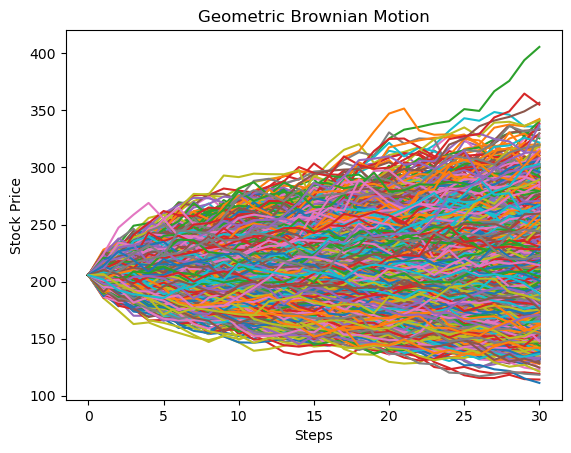

9.973722202135082 (9.910459077122567, 0.2919578568930659, 0.12962053732173853, -0.38515942305742323, 0.0114507086608681)


In [58]:
S0 = 205.66
K = 200
T = .12
r = rf
sigma = sigmas[2]
option_type = 'put'
n_simulations = 5000
n_steps = 30

output = monte_carlo_american_option(S0, K, T, r, sigma, option_type, n_simulations, n_steps)
option_price =output[0]
stock_price_matrix = output[1]
value_tracker_matrix = output[2]
graph = graph_brownian_motion(stock_price_matrix)


b_s = black_scholes(S0, K, T, r, sigma, option_type)
print(option_price,b_s)

In [59]:
sigmas = [sigma_6, sigma_3, sigma_1, sigma_2w]
data = data_call_mult_exp
S0 = float(data_call_mult_exp['Adj Close'][0])
data = data.reset_index()
data = data.drop(['index'], axis= 1)
data = data.drop(data.index[-1])
days = []
for i in range(len(data['Exp Date'])):
        TTM = dt.strptime(data['Exp Date'][i], "%m/%d/%Y") 
        TTM1 = dt.strptime(data['Date'][i], "%m/%d/%Y")
        TTM2 = TTM - TTM1
        TTM3 = TTM2.days - (TTM2.days/7)*2
        days.append(TTM3)
r = rf
strikes = np.arange(220,265,5)
n_simulations =20000
option_type = 'call'

def historical_tests(S0, strikes, days, r, sigma, option_type, n_simulations, data):
    df = pd.DataFrame()
    df['Exp Date']= data['Exp Date']
    df['Days'] = days
    
    for strike in strikes:
        K = strike
        option_prices = []
        for day in days:
            n_steps = int(day)
            T = n_steps/252
            output = monte_carlo_american_option(S0, K, T, r, sigma, option_type, n_simulations, n_steps)
            option_price = output[0]
            option_prices.append(option_price)
        if option_type =='call':
            df['Our '+str(strike)+'C'] = option_prices
        else:
            df['Our '+str(strike)+'P'] = option_prices
    
    
    return df

In [123]:
data = data_call_mult_exp
data = data.reset_index()
data = data.drop(['index'], axis= 1)
data = data.drop(data.index[-1])

S0 = float(data_call_mult_exp['Adj Close'][0])
strikes = np.arange(220,265,5)
days = []
for i in range(len(data['Exp Date'])):
        TTM = dt.strptime(data['Exp Date'][i], "%m/%d/%Y") 
        TTM1 = dt.strptime(data['Date'][i], "%m/%d/%Y")
        TTM2 = TTM - TTM1
        TTM3 = TTM2.days - (TTM2.days/7)*2
        days.append(TTM3)
r=rf
sigma = sigmas[2]
option_type = 'call'
n_simulations = 10000

sig_1mo_call =historical_tests(S0, strikes, days, r, sigma, option_type, n_simulations, data)

In [124]:
sigma = sigmas[1]
sig_3mo_call = historical_tests(S0, strikes, days, r, sigma, option_type, n_simulations, data)

In [125]:
sigma = sigmas[0]
sig_6mo_call = historical_tests(S0, strikes, days, r, sigma, option_type, n_simulations, data)

In [198]:
sigma = sigmas[3]
sig_2w_call = historical_tests(S0, strikes, days, r, sigma, option_type, n_simulations, data)

C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)


In [168]:
sig_1mo_call = round(sig_1mo_call,2)
sig_3mo_call = round(sig_3mo_call,2)
sig_6mo_call = round(sig_6mo_call,2)
sig_6mo_call['Our 240C']

0     6.50
1     8.95
2    11.37
3    12.97
4    14.87
5    16.44
6    18.19
Name: Our 240C, dtype: float64

In [160]:
data

,Exp Date,Date,Adj Close,Close 220C,Close 225C,Close 230C,Close 235C,Close 240C,Close 245C,Close 250C,Close 255C,Close 260C
0,12/8/2023,12/1/2023,238.83,19.7,15.25,11.24,7.75,5.15,3.2,1.95,1.14,0.69
1,12/15/2023,12/1/2023,238.83,21.13,16.8,13.6,10.37,7.75,5.65,4,2.87,2
2,12/22/2023,12/1/2023,238.83,21.8,18.32,15.07,12.2,9.55,7.4,5.68,4.25,3.15
3,12/29/2023,12/1/2023,238.83,23.35,19.2,16.45,13.45,10.85,8.62,6.8,5.28,4.1
4,1/5/2024,12/1/2023,238.83,25.05,21.48,18.5,15.45,13.15,10.55,8.8,7.1,5.86
5,1/12/2024,12/1/2023,238.83,25.4,22.5,19.83,17.08,14.7,12.14,10.15,8.25,6.85
6,1/19/2024,12/1/2023,238.83,27.1,23.88,21.03,18.2,15.65,13.3,11.25,9.5,7.98


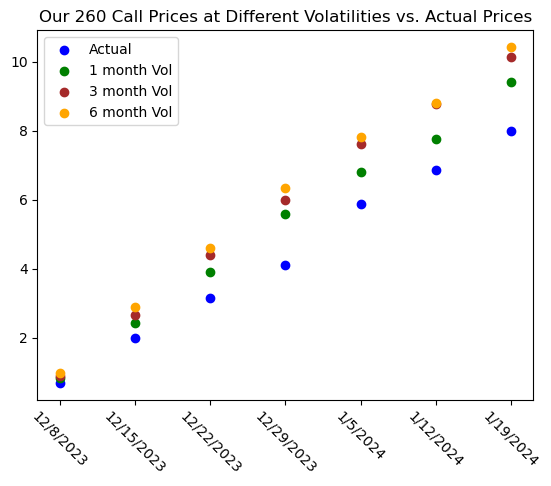

In [193]:
plt.scatter(data['Exp Date'], data['Close 260C'].astype(float),color='blue',label='Actual')
plt.scatter(data['Exp Date'], sig_1mo_call['Our 260C'],color='green',label = '1 month Vol')
plt.scatter(data['Exp Date'], sig_3mo_call['Our 260C'],color='brown', label = '3 month Vol')
plt.scatter(data['Exp Date'], sig_6mo_call['Our 260C'],color='orange',label = '6 month Vol')
plt.title("Our 260 Call Prices at Different Volatilities vs. Actual Prices")
plt.xticks(rotation = -45)
plt.legend()
plt.show()


In [128]:
data_1 = data_put_mult_exp
data_1 = data_1.reset_index()
data_1 = data_1.drop(['index'], axis= 1)
data_1 = data_1.drop(data_1.index[-1])

S0 = float(data_put_mult_exp['Adj Close'][0])
strikes = np.arange(220,265,5)
days = []
for i in range(len(data_1['Exp Date'])):
        TTM = dt.strptime(data_1['Exp Date'][i], "%m/%d/%Y") 
        TTM1 = dt.strptime(data_1['Date'][i], "%m/%d/%Y")
        TTM2 = TTM - TTM1
        TTM3 = TTM2.days - (TTM2.days/7)*2
        days.append(TTM3)
r=rf
sigma = sigmas[2]
option_type = 'put'
n_simulations = 10000

sig_1mo_put = historical_tests(S0, strikes, days, r, sigma, option_type, n_simulations, data_1)

In [129]:
sigma = sigmas[1]
sig_3mo_put = historical_tests(S0, strikes, days, r, sigma, option_type, n_simulations, data_1)

In [130]:
sigma = sigmas[0]
sig_6mo_put = historical_tests(S0, strikes, days, r, sigma, option_type, n_simulations, data_1)

In [197]:
sigma = sigmas[3]
sig_2w_put = historical_tests(S0, strikes, days, r, sigma, option_type, n_simulations, data_1)

C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)


In [199]:
sig_2w_put["Our 240P"]

0     5.467021
1     7.269956
2     8.739082
3     9.792045
4    10.993295
5    11.868784
6    12.819613
Name: Our 240P, dtype: float64

In [19]:
data_1

,Open,High,Low,Close,Adj Close,Volume,Log Returns,Simple Returns
Date,,,,,,,,
2023-09-01,257.26,259.08,242.01,245.01,245.01,132272500,NaN,NaN
2023-09-05,245.00,258.00,244.86,256.49,256.49,129469600,0.045791,0.046855
2023-09-06,255.14,255.39,245.06,251.92,251.92,116959800,-0.017978,-0.017817
2023-09-07,245.07,252.81,243.27,251.49,251.49,115312900,-0.001708,-0.001707
2023-09-08,251.22,256.52,246.67,248.50,248.50,118367700,-0.011960,-0.011889
...,...,...,...,...,...,...,...,...
2023-11-24,233.75,238.75,232.33,235.45,235.45,65125200,0.005280,0.005294
2023-11-27,236.89,238.33,232.10,236.08,236.08,112031800,0.002672,0.002676
2023-11-28,236.68,247.00,234.01,246.72,246.72,148549900,0.044083,0.045069


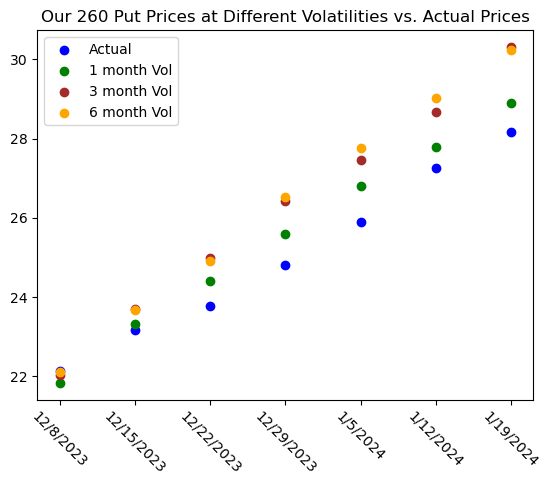

In [201]:
#dates = ['12/8/23','12/15/23','12/22/23','12/29/23','']
plt.scatter(data_1['Exp Date'], data_1['Close 260P'].astype(float),color='blue',label='Actual')

plt.scatter(data_1['Exp Date'], sig_1mo_put['Our 260P'],color='green', label = '1 month Vol')
plt.scatter(data_1['Exp Date'], sig_3mo_put['Our 260P'],color='brown', label = '3 month Vol')
plt.scatter(data_1['Exp Date'], sig_6mo_put['Our 260P'],color='orange',label = '6 month Vol')
plt.title("Our 260 Put Prices at Different Volatilities vs. Actual Prices")
plt.xticks(rotation = -45)
plt.legend()
plt.show()


In [68]:
S0 = 238.83
sigma= .366
K=260
n_steps = 5
r= rf
T= n_steps/252
option_type = 'call'
n_simulations = 20000

output = monte_carlo_american_option(S0, K, T, r, sigma, option_type, n_simulations, n_steps)
output[0]

C:\Users\bjorn\AppData\Local\Temp\ipykernel_30220\1397610535.py:59: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 2)


0.2876388619193469

In [69]:
print(sigmas)

[0.5009300757766552, 0.4959531028911172, 0.4686274757701408, 0.3662065279376032]


x = n_sims_arr
x = sm.add_constant(x)
y = prices
model = sm.OLS(y, x)
results = model.fit()
predict = results.predict(x)
plt.plot(n_sims_arr,predict)
plt.scatter(n_sims_arr,y)
plt.grid()
plt.show

n, bins, patches = plt.hist(stock_price_matrix[:,-1],bins=300);
for c, p in zip(bins, patches):
    if option_type == 'put' :
        if c < K:
            plt.setp(p, 'facecolor', 'green')
        else:
            plt.setp(p, 'facecolor', 'red')
    else:
        if c > K:
            plt.setp(p, 'facecolor', 'green')
        else:
            plt.setp(p, 'facecolor', 'red')
plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")
plt.title("In the Money/Out of the Money for European Options")
plt.xlabel("$S_{T}$")
plt.ylabel('Count')
plt.legend()

exercise_values=[]
for i in range(n_simulations):
    x = value_tracker_matrix[i,:]>0
    if value_tracker_matrix[i,:][1] == 0:
        exercise_values.append(0)
    else:
        loc = np.argwhere(x == 1).max()
        exercise_values.append(value_tracker_matrix[i][loc])

n, bins, patches = plt.hist(exercise_values,bins=50);
for c, p in zip(bins, patches):
        if c > 0 :
            plt.setp(p, 'facecolor', 'green')
        else:
            plt.setp(p, 'facecolor', 'red')
plt.title("Value when American Option was exercised")
plt.xlabel("$S_{T}$")
plt.ylabel('Count')


### Another way we can generate monte carlo simulations

This way we make price paths and add them all to z to be graphed, we can split z up and then calculate the options price based on this. This initially creates a matrix of nxdt normally distributed random variables and manipulates them to simulate brownian motion

def monte_carlo_simulation(n, T, S0, K, mu = 0, sigma = 1):
    u = []
    z = []
    dt= math.floor(T*252)
    # random normal variables mean mu and std dev. sigma/dt^(1/2)
    u = mu + np.random.randn(n,dt)*sigma/math.sqrt(dt)
    
    z = np.cumprod(1 + u,1)*S0
    
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title("Geometric Brownian Motion")
    for i in z: plt.plot(i)
    plt.show()
    print(z)

    
    

#a Github example from the longstaff schwartz paper.
N = 4  # number of time steps
r = 0.06  # interest rate
K = 1.1  # strike
T = .1  # Maturity

dt = T / (N - 1)  # time interval
df = np.exp(-r * dt)  # discount factor per time interval
S = np.array(
    [
        [1.00, 1.09, 1.08, 1.00],
        [1.00, 1.16, 1.26, 1.],
        [1.00, 1.22, 1.07, 1.03],
        [1.00, 0.93, 0.97, 0.9],
        [1.00, 1.11, 1.56, 1.],
        [1.00, 0.76, 0.77, 0.90],
        [1.00, 0.92, 0.84, 1.01],
        [1.00, 0.88, 1.22, 1.],
    ]
)
print(S[0,:])
print(dt)
print(df)

H = np.maximum(K - S, 0)  # intrinsic values for put option (value if exercised at that time)
V = np.zeros_like(H)  # value matrix if exercise or continue
V[:, -1] = H[:, -1] #last column of value matrix equal to the last column of intrinsic value matrix

# Valuation by LS Method
for t in range(N - 2, 0, -1):
    print(t)
    print(H[:,t])
    good_paths = H[:, t] > 0  # paths where the intrinsic value is positive
    print(good_paths)
    print(S[good_paths, t])
    # the regression is performed only on these paths
    rg = np.polynomial.polynomial.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, 2)  # polynomial regression
    C = np.polynomial.polynomial.polyval( S[good_paths, t],rg)  # evaluation of regression
    print("polyval: " +str(C))
    exercise = np.zeros(len(good_paths), dtype=bool)  # initialize
    exercise[good_paths] = H[good_paths, t] > C  # paths where it is optimal to exercise
    print(exercise)
    V[exercise, t] = H[exercise, t]  # set V equal to H where it is optimal to exercise
    print(V)
    V[exercise, t + 1 :] = 0  # set future cash flows, for that path, equal to zero
    print(V)
    discount_path = V[:, t] == 0  # paths where we didn't exercise
    print(discount_path)
    V[discount_path, t] = V[discount_path, t + 1] * df  # set V[t] in continuation region
    print(V)
    
print(V)
print(V[:, 1])
V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
print("Example price= ", V0)

In [ ]:
rf

In [ ]:
pt_x_1mo= [220,230,240,250,260]
pt_yc_1mo = [.4165, .4135, .4075, .4068, .4097]

pt_yp_1mo = [.4239, .4138,.4103,.4095, .4374]

In [ ]:

fig, ((ax1, ax2)) = plt.subplots(1, 2)


ax1.scatter(pt_x_1mo,pt_yc_1mo)
ax1.set_title("1 Month Call Volatility")
ax2.scatter(pt_x_1mo,pt_yp_1mo)
ax2.set_title("1 Month Put Volatility")
fig.tight_layout()
plt.show()

In [ ]:
S = 238.83
K= 260
T = 10/252
r=rf
sigma = .4389
black_scholes(S, K, T, r, sigma, option_type='call')

In [ ]:
pt_x_2w= [220,225,230,235,240,245,250,255,260]
pt_yc_2w = [.4581,.4134,.4359,.4268,.4252,.4255,.4256,.4337,.4389]
pt_yp_2w = [.4487,.4395,.4359,.4318,.4279,.4278,.4357,.4467,.4787]

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2)
ax1.scatter(pt_x_2w,pt_yc_2w)
ax1.set_title("2 Week Call Volatility")
ax2.scatter(pt_x_2w,pt_yp_2w)
ax2.set_title("2 Week Put Volatility")
fig.tight_layout()
plt.show()